In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
 

In [2]:

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
 
# CIFAR-10 dataset

#train dataset transformations
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4), # randomly crops the image and pads it with 4 pixels
    transforms.RandomHorizontalFlip(), # randomly flips the image horizontally
    transforms.RandomRotation(degrees=15), # randomly rotates the image by 15 degrees
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # normalizes the tensor using mean and standard deviation values

])

#test dataset transformations
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
 
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=train_transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=test_transform)
 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
    
 


Files already downloaded and verified


In [3]:
 
#Basic Block, consisting of two convolutional layers with batch normalization and a shortcut connection
class BasicBlock(nn.Module): 
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut connection to adjust input dimensions to match output.
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
 
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# Takes an input image with 3 channels (RGB) and outputs a tensor of size 10, which represents the 10 classes in the CIFAR-10 dataset.
class ModifiedResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ModifiedResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64) # Batch normalization layer for the above 1st convolutional layer
        # Layers 1-3, each consisting of multiple BasicBlock units
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.avg_pool = nn.AvgPool2d(kernel_size=8) # Global average pooling layer
        self.Dropout = nn.Dropout(0.5) # Dropout layer to reduce overfitting
        self.linear = nn.Linear(256, num_classes) # Fully connected output layer
 
    def _make_layer(self, block, out_channels, num_blocks, stride):
        # Strides for each block
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            # Add a block to the layer
            layers.append(block(self.in_channels, out_channels, stride))
            # Update the number of input channels
            self.in_channels = out_channels
        return nn.Sequential(*layers)
 
    def forward(self, x):
        # Input image passed through the 1st convolutional layer and batch normalization layer, followed by layers 1-3, a global average pooling layer, dropout layer, and finally the fully connected output layer
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = self.Dropout(out)
        out = out.view(out.size(0), -1)
        h = x.view(x.shape[0], -1)
        out = self.linear(out)
        return out
 
# Model instance
model = ModifiedResNet(BasicBlock, [2, 2, 3]).to(device)


In [4]:
 
# Loss function, optimizer and scheduler 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# function to calculate accuracy
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc
 

In [5]:
num_epochs = 60       # The number of epochs to train the model
train_accuracy = []   # Empty list to store accuracy values for each epoch
train_loss = []       # Empty list to store loss values for each epoch
best_train_loss=0     # Initialize the best training loss to 0

# Iterate over the specified number of epochs
for epoch in range(num_epochs):
    epoch_acc = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        output = model(images)
        loss = criterion(output, labels)
        acc = calculate_accuracy(output, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_acc += acc.item()
    # Adjust the learning rate using a step scheduler
    scheduler.step() 

    # Print the loss and accuracy for the current epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {epoch_acc / len(train_loader)}')
    
    # Append the accuracy and loss for the current epoch to their respective lists
    train_accuracy.append(epoch_acc / len(train_loader))
    train_loss.append(loss.item())

    # Save the model if the current training loss is the best so far
    if loss < best_train_loss:
        best_train_loss = loss
        torch.save(model.state_dict(), 'best_model.pt')

    # Evaluate the model on the test set
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate and print the test accuracy
    accuracy = 100 * correct / total
    print(f'Test Accuracy of the model on the 10000 test images: {accuracy:.2f}%')

Epoch [1/60], Loss: 1.2276, Accuracy: 0.33123400511836215
Test Accuracy of the model on the 10000 test images: 49.05%
Epoch [2/60], Loss: 1.3501, Accuracy: 0.5052383237364043
Test Accuracy of the model on the 10000 test images: 59.17%
Epoch [3/60], Loss: 0.8741, Accuracy: 0.6080254318618042
Test Accuracy of the model on the 10000 test images: 65.60%
Epoch [4/60], Loss: 1.0932, Accuracy: 0.6621281190019194
Test Accuracy of the model on the 10000 test images: 70.98%
Epoch [5/60], Loss: 0.7368, Accuracy: 0.7017754318618042
Test Accuracy of the model on the 10000 test images: 73.68%
Epoch [6/60], Loss: 0.6631, Accuracy: 0.7354446577095329
Test Accuracy of the model on the 10000 test images: 76.36%
Epoch [7/60], Loss: 0.7682, Accuracy: 0.7587172104926424
Test Accuracy of the model on the 10000 test images: 77.68%
Epoch [8/60], Loss: 0.5296, Accuracy: 0.7752319257837492
Test Accuracy of the model on the 10000 test images: 78.81%
Epoch [9/60], Loss: 0.4145, Accuracy: 0.7896673064619322
Test A

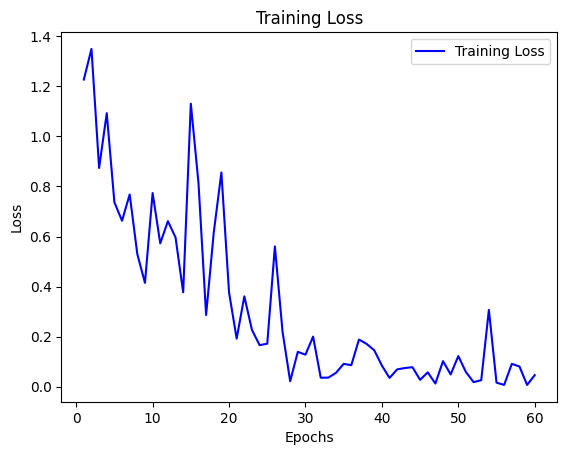

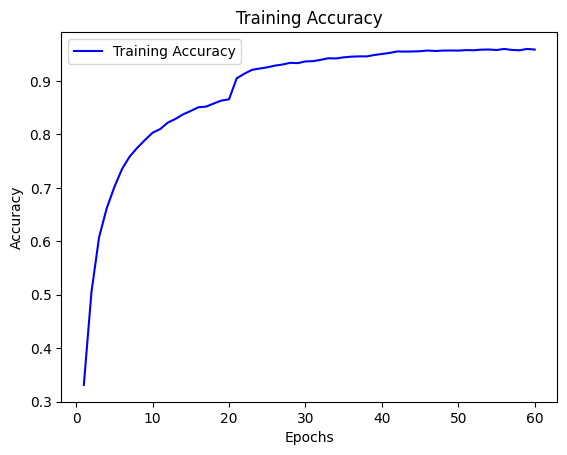

In [6]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_accuracy) + 1)

# Plot train loss
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Plot train accuracy
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()